In [2]:
import cv2 as cv
import numpy as np

In [3]:
left  = cv.imread('CameraCalibTestPhotos/640x480/imgL1.jpg')
right = cv.imread('CameraCalibTestPhotos/640x480/imgR1.jpg')

In [4]:
def get_intrinsics(file_path):
        # Open the file storage for reading
        cv_file = cv.FileStorage(file_path, cv.FILE_STORAGE_READ)

        intrinsics = {}
        # Read the left stereo map (x coordinates)
        intrinsics['Left_Stereo_Map_x'] = cv_file.getNode("Left_Stereo_Map_x").mat()

        # Read the left stereo map (y coordinates)
        intrinsics['Left_Stereo_Map_y'] = cv_file.getNode("Left_Stereo_Map_y").mat()

        # Read the right stereo map (x coordinates)
        intrinsics['Right_Stereo_Map_x'] = cv_file.getNode("Right_Stereo_Map_x").mat()

        # Read the right stereo map (y coordinates)
        intrinsics['Right_Stereo_Map_y'] = cv_file.getNode("Right_Stereo_Map_y").mat()

        # Read the rectified camera matrix
        intrinsics['Rectifyed_mat_left'] = cv_file.getNode("Rectifyed_mat_left").mat()
        
        intrinsics['Mat_left'] = cv_file.getNode("Mat_left").mat()
        # Read the baseline (distance between the two cameras)
        intrinsics['Baseline'] = cv_file.getNode("Baseline").real()

        return intrinsics

intrinsics = get_intrinsics('./intrinsics.xml')
intrinsics

{'Left_Stereo_Map_x': array([[[359, 705],
         [359, 705],
         [358, 705],
         ...,
         [311, 682],
         [311, 682],
         [311, 682]],
 
        [[359, 704],
         [358, 704],
         [358, 704],
         ...,
         [311, 682],
         [311, 682],
         [311, 682]],
 
        [[358, 704],
         [358, 704],
         [358, 704],
         ...,
         [311, 681],
         [311, 681],
         [311, 681]],
 
        ...,
 
        [[307, 401],
         [307, 401],
         [307, 401],
         ...,
         [304, 424],
         [304, 424],
         [304, 424]],
 
        [[307, 400],
         [307, 400],
         [307, 400],
         ...,
         [304, 423],
         [304, 423],
         [304, 423]],
 
        [[307, 400],
         [307, 400],
         [307, 400],
         ...,
         [304, 423],
         [304, 423],
         [304, 423]]], dtype=int16),
 'Left_Stereo_Map_y': array([[  8,  67, 125, ..., 359, 328, 297],
        [835, 893, 919, ...

In [5]:
from utils import depth_to_pcl, process_images, disparity_to_depth

In [6]:
def create_bev_image(
        image_size,
        points,
        path_to_save="bev.png"
):
    truncated_points = points
    y_img = truncated_points[:, 0]
    x_img = -truncated_points[:, 1]
    pixels = truncated_points[:, 0]

    xy = truncated_points[:, :-1]
    dist = np.linalg.norm(xy, axis=-1)
    
    
    fig, ax = plt.subplots(figsize=(2000 / 200, 2000 / 200), dpi=100)
    ax.scatter(x_img, y_img, s=1, c=dist, alpha=1.0, cmap='jet')
    
    ax.scatter([0], [0], s=5, alpha=1.0, color=(0.5, 0.5, 0.5))
    ax.set_facecolor((1.0, 1.0, 1.0))
    ax.axis('scaled')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plt.savefig(path_to_save, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    
    
import numpy as np
import vispy.scene
from vispy.scene import visuals
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def draw_pcl(pcl, camera_type='fly'):

    canvas = vispy.scene.SceneCanvas(keys='interactive', show=True)
    view = canvas.central_widget.add_view()

    # create scatter object and fill in the data
    scatter = visuals.Markers()
    scatter.set_data(pcl * 100, edge_width=0, face_color=(1, 1, 1, .5), size=3)

    view.add(scatter)
    if camera_type == 'fly':
        view.camera = vispy.scene.FlyCamera(fov=90., center=[0.0, 0.0, 0.0])
    elif camera_type == 'turntable':
        view.camera = vispy.scene.TurntableCamera(fov=90., center=[0.0, 0.0, 0.0], name='fly', elevation=0.0, azimuth=0.0)
        
    axis = visuals.XYZAxis(parent=view.scene)
    vispy.app.run()    

In [7]:
image_size = (left.shape[1], left.shape[0])
print(image_size)

rectified_left = cv.remap(left, intrinsics['Left_Stereo_Map_x'], intrinsics['Left_Stereo_Map_y'], cv.INTER_LINEAR)
rectified_right = cv.remap(right, intrinsics['Right_Stereo_Map_x'], intrinsics['Right_Stereo_Map_y'], cv.INTER_LINEAR)

(640, 480)


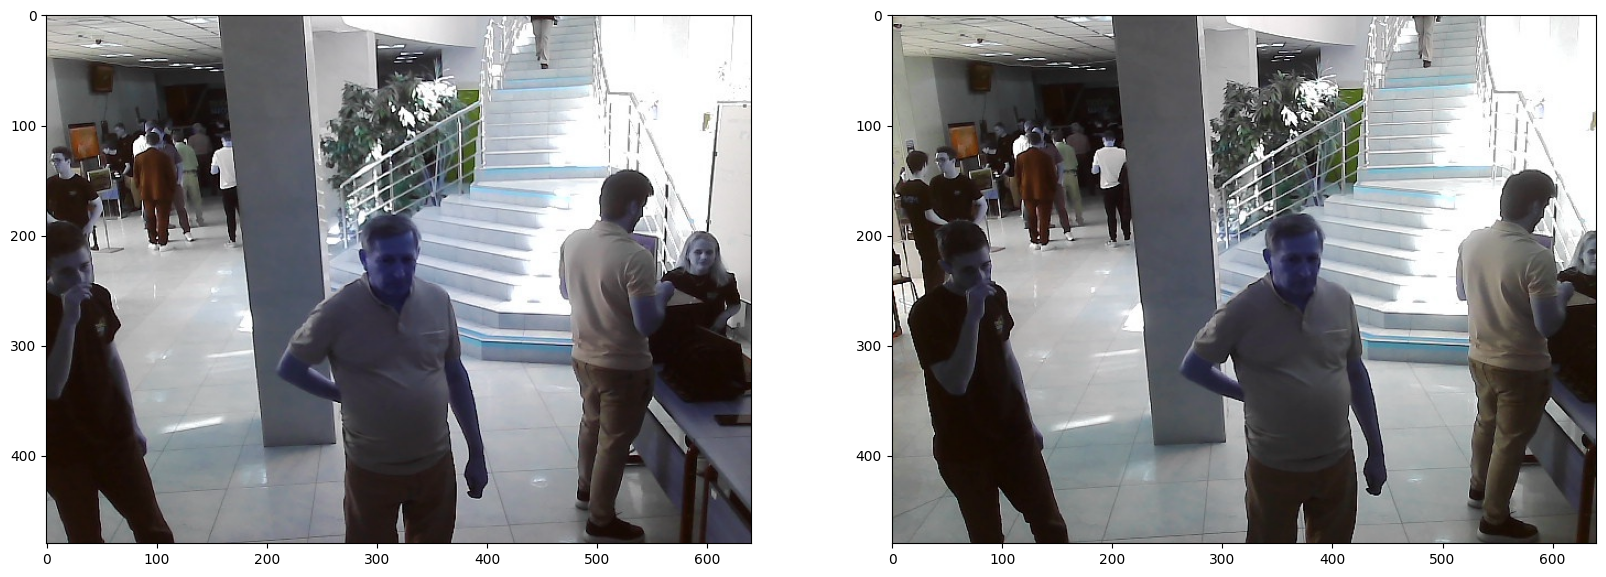

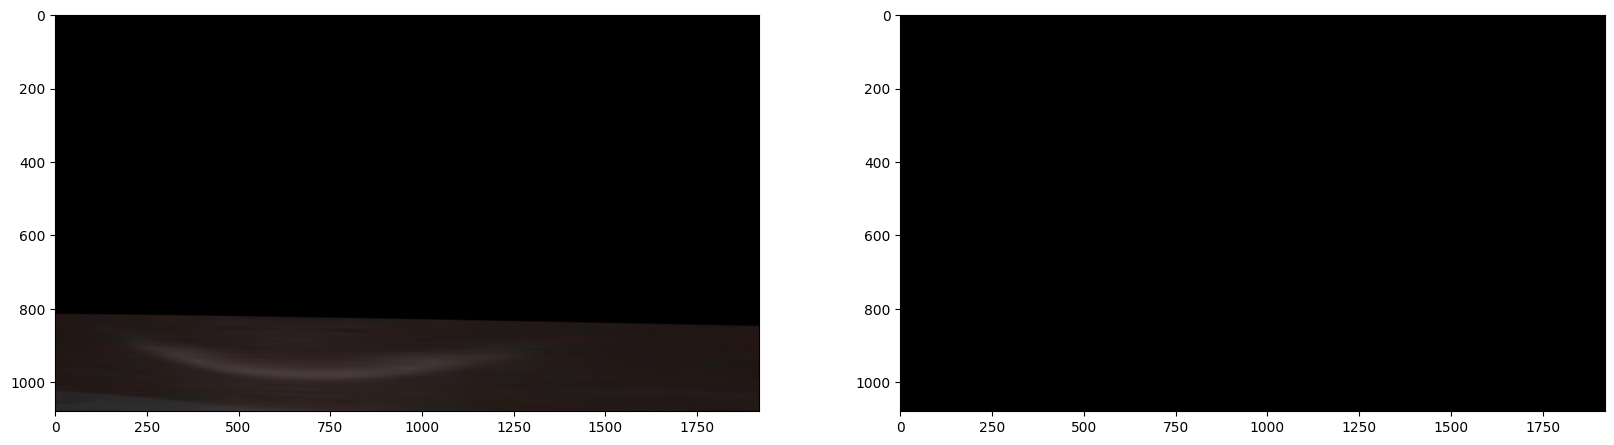

In [8]:
f, (ax1, ax2) = plt.subplots(ncols=2)
f.set_figheight(10)
f.set_figwidth(20)
ax1.imshow(left)
ax2.imshow(right)
plt.show()

f, (ax1, ax2) = plt.subplots(ncols=2)
f.set_figheight(10)
f.set_figwidth(20)
ax1.imshow(rectified_left)
ax2.imshow(rectified_right)
plt.show()

In [19]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

def load_trt_engine(engine_path):
        '''
        Load TRT engine
        '''
        TRT_LOGGER = trt.Logger(trt.Logger.INFO)
        with open(engine_path, 'rb') as f, trt.Runtime(TRT_LOGGER) as runtime:
            engine = runtime.deserialize_cuda_engine(f.read())
        return engine

def process_images(engine, left_img, right_img):
        '''
        Convert images to CHW format
        Run inference
        Return disparity
        '''

        # Run inference
        context = engine.create_execution_context()

        # rectified_left = cv.remap(left_img, intrinsics['Left_Stereo_Map_x'], intrinsics['Left_Stereo_Map_y'], cv.INTER_LINEAR)
        # rectified_right = cv.remap(right_img, intrinsics['Right_Stereo_Map_x'], intrinsics['Right_Stereo_Map_y'], cv.INTER_LINEAR)
        rectified_left = left_img
        rectified_right = right_img
        target_height, target_width = 480, 640 # Sizes for current model TODO params of the model
        left_img_res = cv.resize(rectified_left, (target_width, target_height))
        right_img_res = cv.resize(rectified_right, (target_width, target_height))
        cv.imshow('left', rectified_left)
        cv.imshow('right', rectified_right)
        cv.waitKey(0)
        cv.destroyAllWindows()
        # Convert to CHW format for TRT and ensure they are contiguous
        left_img_chw = left_img_res.transpose((2, 0, 1)).astype('float32')
        right_img_chw = right_img_res.transpose((2, 0, 1)).astype('float32')

        input_tensor = np.ascontiguousarray(np.array([left_img_chw, right_img_chw]))
        input_tensor = np.expand_dims(input_tensor, axis=0)
        output = np.empty((1, 480, 640, 1), dtype=np.float32)
        d_input = cuda.mem_alloc(input_tensor.nbytes)
        d_output = cuda.mem_alloc(output.nbytes)

        context.set_tensor_address(engine.get_tensor_name(0), int(d_input)) # input buffer
        context.set_tensor_address(engine.get_tensor_name(1), int(d_output)) # output buffer

        stream = cuda.Stream()
        # Copy images to the GPU
        cuda.memcpy_htod_async(d_input, input_tensor, stream)

        success = context.execute_async_v3(stream_handle=stream.handle)
        print(success)
        # Copy result from GPU
        cuda.memcpy_dtoh_async(output, d_output, stream)
        stream.synchronize()
        output = np.squeeze(output, axis=(0, 3))  # Shape: [720, 1280]

        return output
    
def disparity_to_depth(disparity):
    '''
    Convert disparity to depth
    '''
    # Filter some invalid values
    disparity[disparity <= 0] = None
    disparity[disparity > 3000] = None
    return (intrinsics['Baseline'] * intrinsics['Mat_left'][0, 0]) / disparity

In [20]:
engine = load_trt_engine('model.engine')

In [21]:
disparity = process_images(engine, left, right)
depth = disparity_to_depth(disparity)
print(depth.shape)

True
(480, 640)


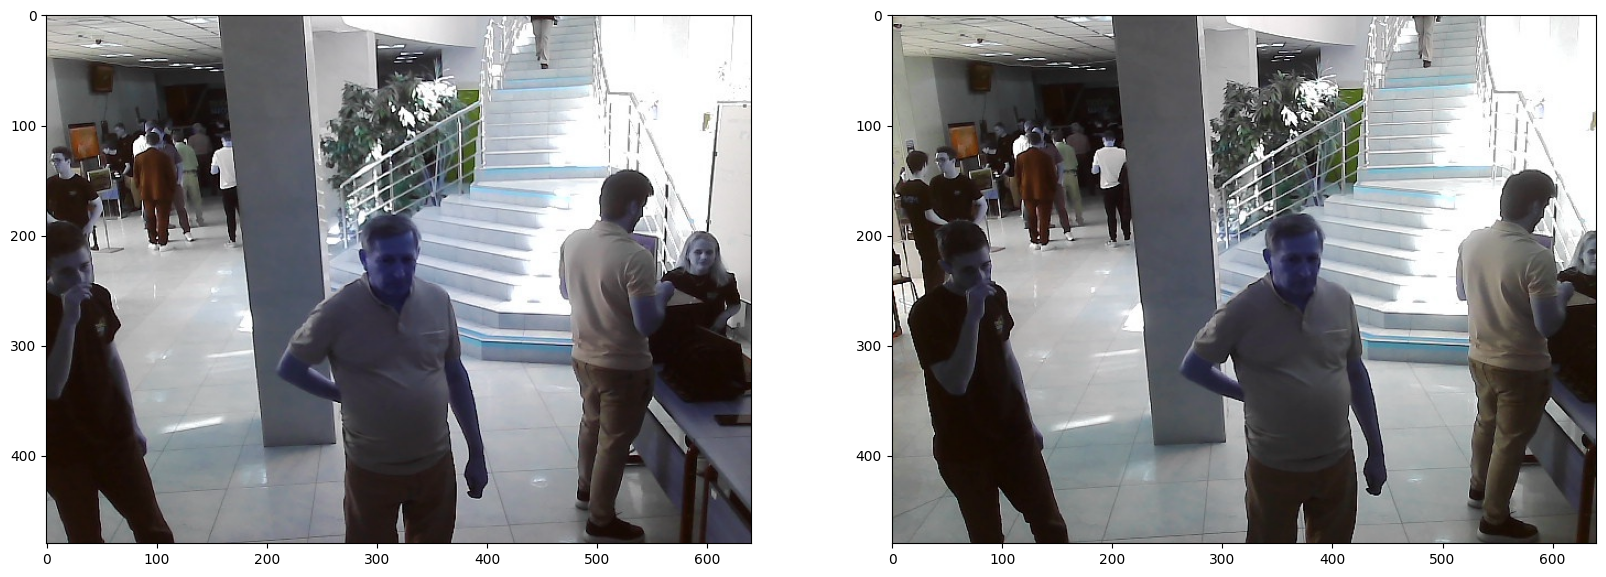

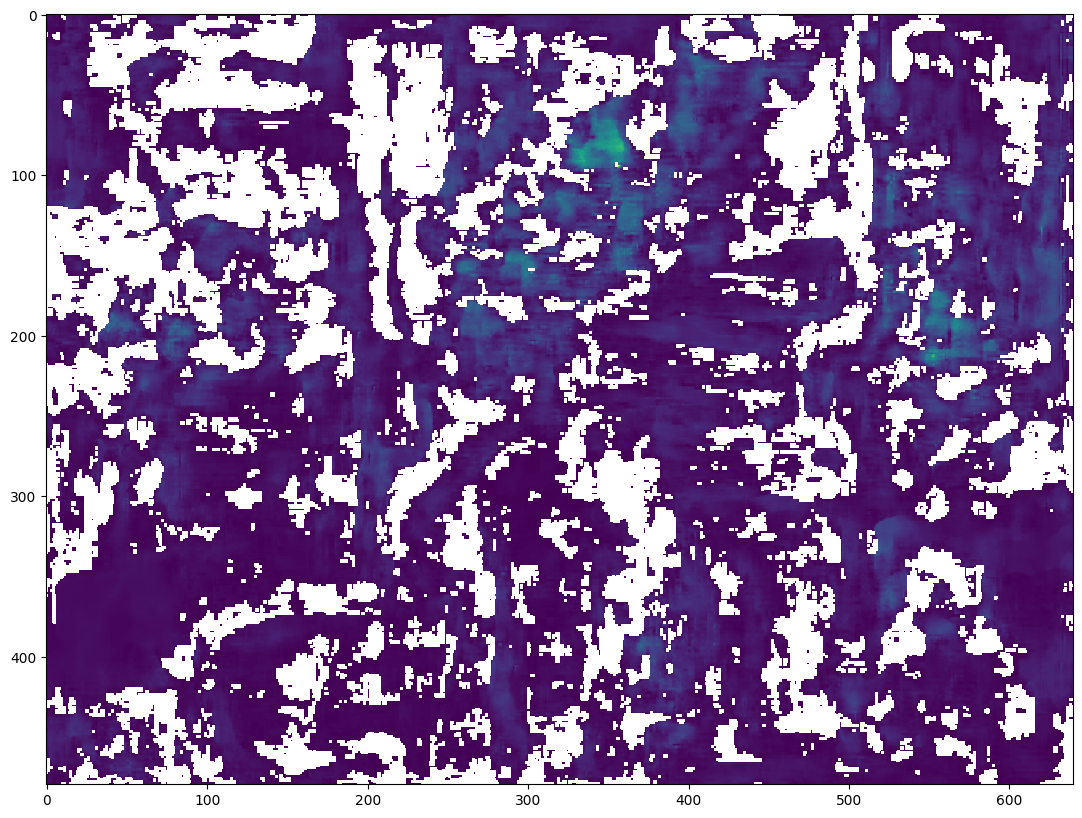

In [22]:
f, (ax1, ax2) = plt.subplots(ncols=2)
f.set_figheight(10)
f.set_figwidth(20)
ax1.imshow(left)
ax2.imshow(right)
plt.show()
f = plt.figure(figsize=(10, 20))
f.set_figheight(10)
f.set_figwidth(20)
plt.imshow(disparity)
plt.show()

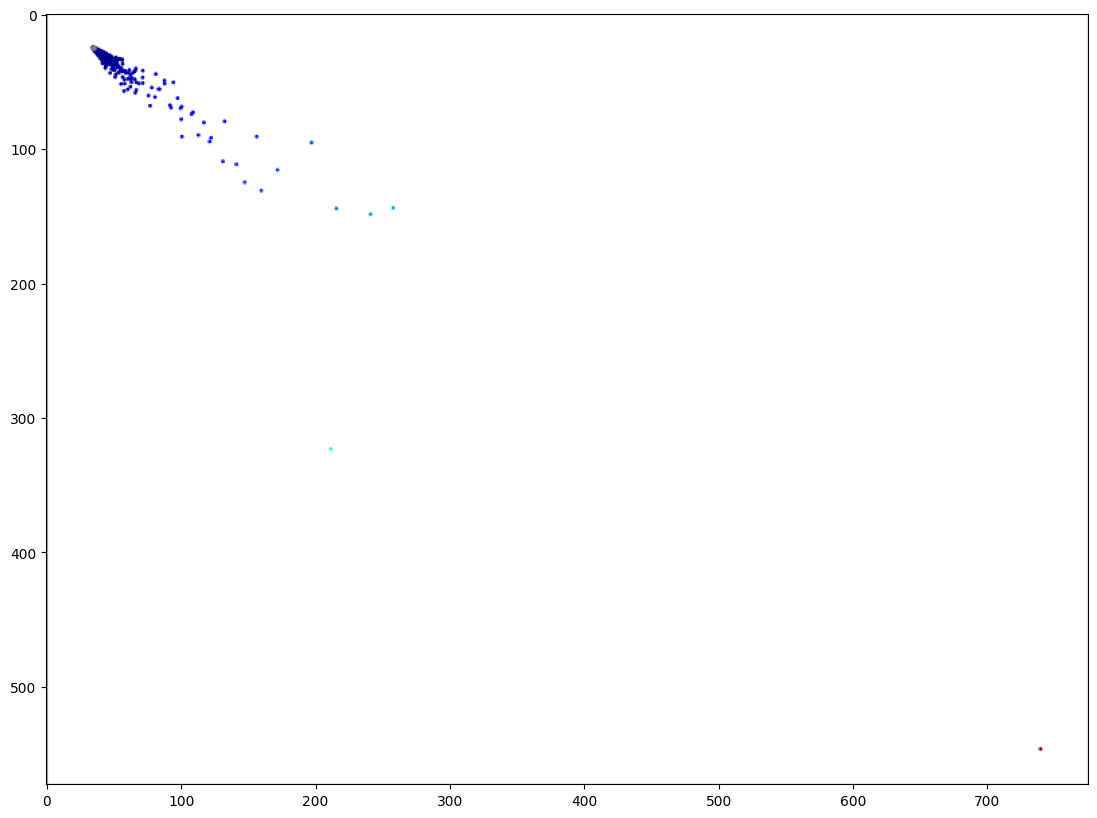

In [23]:
pcl = depth_to_pcl(depth, intrinsics['Mat_left'])
create_bev_image((1000, 1000), pcl, "bev.png")



bev_im = plt.imread("bev.png")
f = plt.figure(figsize=(10, 20))
f.set_figheight(10)
f.set_figwidth(20)
plt.imshow(bev_im)
plt.show()

In [14]:
import pandas as pd
import plotly.graph_objects as go

In [24]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=pcl[:,0], y=pcl[:,1], z=pcl[:,2]
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)

In [26]:
import numpy as np
import open3d as o3d

def create_point_cloud_from_depth_image(depth_image, intrinsic_matrix):
    # Create an Open3D image from the depth image
    depth_o3d = o3d.geometry.Image(depth_image)


    # Create a pinhole camera intrinsic object from the intrinsic matrix
    width = depth_image.shape[1]
    height = depth_image.shape[0]
    fx = intrinsic_matrix[0, 0]
    fy = intrinsic_matrix[1, 1]
    cx = intrinsic_matrix[0, 2]
    cy = intrinsic_matrix[1, 2]

    intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

    # Convert depth image to point cloud
    pcd = o3d.geometry.PointCloud.create_from_depth_image(
        depth_o3d,
        intrinsic,
        depth_scale=1000.0,  # Adjust if depth values are in millimeters
        depth_trunc=3000.0,  # Set the maximum depth to consider
        project_valid_depth_only = False
    )
    
    return pcd

In [27]:

pcd = create_point_cloud_from_depth_image(depth, intrinsics['Mat_left'])

In [28]:
o3d.visualization.draw_geometries([pcd])